# Traceur GPS

Sommaire:
- [Fichier GPX](#Fichier-GPX)
- [Afficher sur une carte IGN](#Afficher-sur-une-carte-IGN)

## Fichier GPX

C'est un format de fichier qui permet l'échange de données GPS.
- Pour charger le fichier:

In [1]:
import xml.dom.minidom as dom

doc = dom.parse('gpx/trace.gpx')

- Pour afficher son contenu sous forme arborescente:

In [2]:
print(doc.toprettyxml(indent='  ', newl=''))

<?xml version="1.0" ?><gpx xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="Geolives" version="1.1" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd">  
    <metadata/>  
    <trk>    
        <trkseg>      
            <trkpt lat="44.859225" lon="5.559048">        
                <ele>1118.9</ele>        
                <time>2014-07-03T09:56:09Z</time>        
            </trkpt>      
            <trkpt lat="44.859225" lon="5.558792">        
                <ele>1105.1621</ele>        
                <time>2014-07-03T09:56:49Z</time>        
            </trkpt>      
            <trkpt lat="44.859249" lon="5.558703">        
                <ele>1105.1621</ele>        
                <time>2014-07-03T09:56:54Z</time>        
            </trkpt>      
            <trkpt lat="44.859262" lon="5.558614">        
                <ele>1109.7183</ele>        
                <time

- Pour récupérer les informations de géolocalisation:

In [3]:
# Récupérer les éléments de type trkpt
pt = doc.getElementsByTagName('trkpt')

# Remplir les tableaux de latitudes et longitudes
latitudes = []
longitudes = []
for p in pt:
    latitudes.append(float(p.getAttribute('lat')))
    longitudes.append(float(p.getAttribute('lon')))

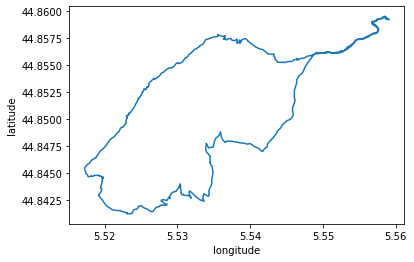

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(longitudes, latitudes)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

## Afficher sur une carte IGN

- Bibliothèque de cartographie IGN (Cf. [Cartographie WMTS](Cartographie_WMTS-2022.ipynb))

In [8]:
import math
from PIL import Image, ImageDraw
import requests
import xml.dom.minidom as dom
import os

ROUGE = (255,0,0)
GRIS = (120,120,120)
BLEU = (0,0,255)

R_TERRE = 6_378_137
CIRCONF = int(2 * math.pi * R_TERRE)

def wmts(latitude, longitude):
    '''
    Calcule les coordonnées en mètres WMTS
    d'une géolocalisation donnée (latitude et longitude en degrés)
    '''
    return (CIRCONF/2 + R_TERRE * math.radians(longitude),
        CIRCONF/2 - R_TERRE * math.log(math.tan(math.radians(latitude)/2 + math.pi/4)) )

def etendue_tuile(niveau):
    return (CIRCONF / (2**niveau))
etendue_tuile(2)

def tuile_info(latitude, longitude, niveau=15):
    '''
    Calcule les indices de ligne et de colonne de la tuile
    contenant la géolocalisation ainsi que les coordonnées
    x et y (en pixel) de cette géolocalisation dans cette
    tuile.
    '''
    cote = etendue_tuile(niveau)
    coord = wmts(latitude, longitude)
    ligne, colonne = int(coord[1]/cote), int(coord[0]/cote)
    x = int(math.modf(coord[0]/cote)[0] * 256)
    y = int(math.modf(coord[1]/cote)[0] * 256)
    return ligne, colonne, x, y

def get_tuile_ign(l, c, niveau=15, ortho=False):
    url = (f"https://wxs.ign.fr/essentiels/geoportail/wmts/?"
           "SERVICE=WMTS&VERSION=1.0.0&REQUEST=GetTile"
           "&TILEMATRIXSET=PM" 
           f"&TILEMATRIX={niveau}&TILEROW={l}&TILECOL={c}"
           f"&STYLE=normal")
    if ortho:
        url = url + "&LAYER=ORTHOIMAGERY.ORTHOPHOTOS&FORMAT=image/jpeg"
    else:
        url = url + "&LAYER=GEOGRAPHICALGRIDSYSTEMS.PLANIGNV2&FORMAT=image/png"
    
    return Image.open(requests.get(url, stream=True).raw)

def get_geo_tuile_ign(latitude, longitude, niveau=15, ortho=False, dispLoc=False):
    (l,c, x, y) = tuile_info(latitude, longitude, niveau)
    t = get_tuile_ign(l, c, niveau, ortho)
    if dispLoc:
        draw = ImageDraw.Draw(t)
        draw.ellipse([(x-4, y-4), (x+4, y+4)], (255,0,0))
    return t

- Dessiner la trace GPX sur une carte:

In [9]:
import ipywidgets as widgets

def affiche_trace_sur_carte(fichier):
    '''
    Afficher une trace GPX sur une carte IGN de niveau 15.
    '''
    doc = dom.parse(fichier)
    
    # Extraire les latitudes et longitudes
    pt = doc.getElementsByTagName('trkpt')
    latitudes = []
    longitudes = []
    for p in pt:
        latitudes.append(float(p.getAttribute('lat')))
        longitudes.append(float(p.getAttribute('lon')))
    
    # Identifier les tuiles utiles
    lmax = cmax = 0
    lmin = cmin = 2**16
    for i in range(len(latitudes)):
        (l, c, x, y ) = tuile_info(latitudes[i], longitudes[i])
        if l<lmin: lmin = l
        if l>lmax: lmax = l
        if c<cmin: cmin = c
        if c>cmax: cmax = c

    progression = widgets.FloatProgress(value=0,min=0,max=100,description='Chargement : ')
    display(progression)

    # Récupérer les tuiles utiles
    carte = Image.new('RGB', ((cmax+1-cmin)*256, (lmax+1-lmin)*256))
    print(f'Tuiles: l={lmin}-{lmax} / c={cmin}-{cmax}')
    num_tuiles = (lmax+1-lmin)*(cmax+1-cmin)
    compteur = 0
    for l in range(lmin, lmax+1):
        for c in range(cmin, cmax+1):
            compteur += 1
            progression.value = compteur*100.0/num_tuiles
            
            # Utilisation d'un cache
            fichier = os.path.join(os.path.expanduser('~'), f".jrandoIGN/cache/z15-r{l}-c{c}.jpg")
            if os.path.exists(fichier):
                t = Image.open(fichier)
            else:
                t = get_tuile_ign(l,c)
            carte.paste(t, (256*(c-cmin), 256*(l-lmin)))
    progression.close()
            
    trace = []
    for i in range(len(latitudes)):
        (l, c, x, y ) = tuile_info(latitudes[i], longitudes[i])
        trace.append( ((c-cmin)*256+x, (l-lmin)*256+y) )
    draw = ImageDraw.Draw(carte)
    draw.line(trace, ROUGE, 5)
    
    display(carte)

FloatProgress(value=0.0, description='Chargement : ')

Tuiles: l=11805-11807 / c=16886-16889


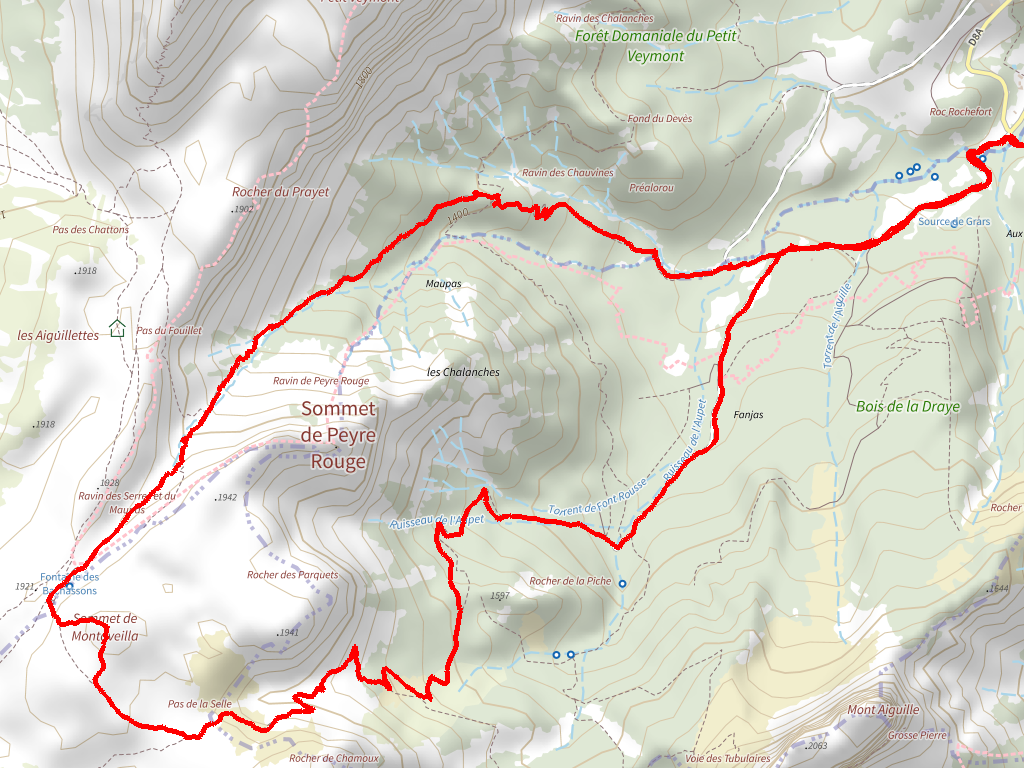

In [10]:
affiche_trace_sur_carte('gpx/trace.gpx')

FloatProgress(value=0.0, description='Chargement : ')

Tuiles: l=11794-11800 / c=16884-16889


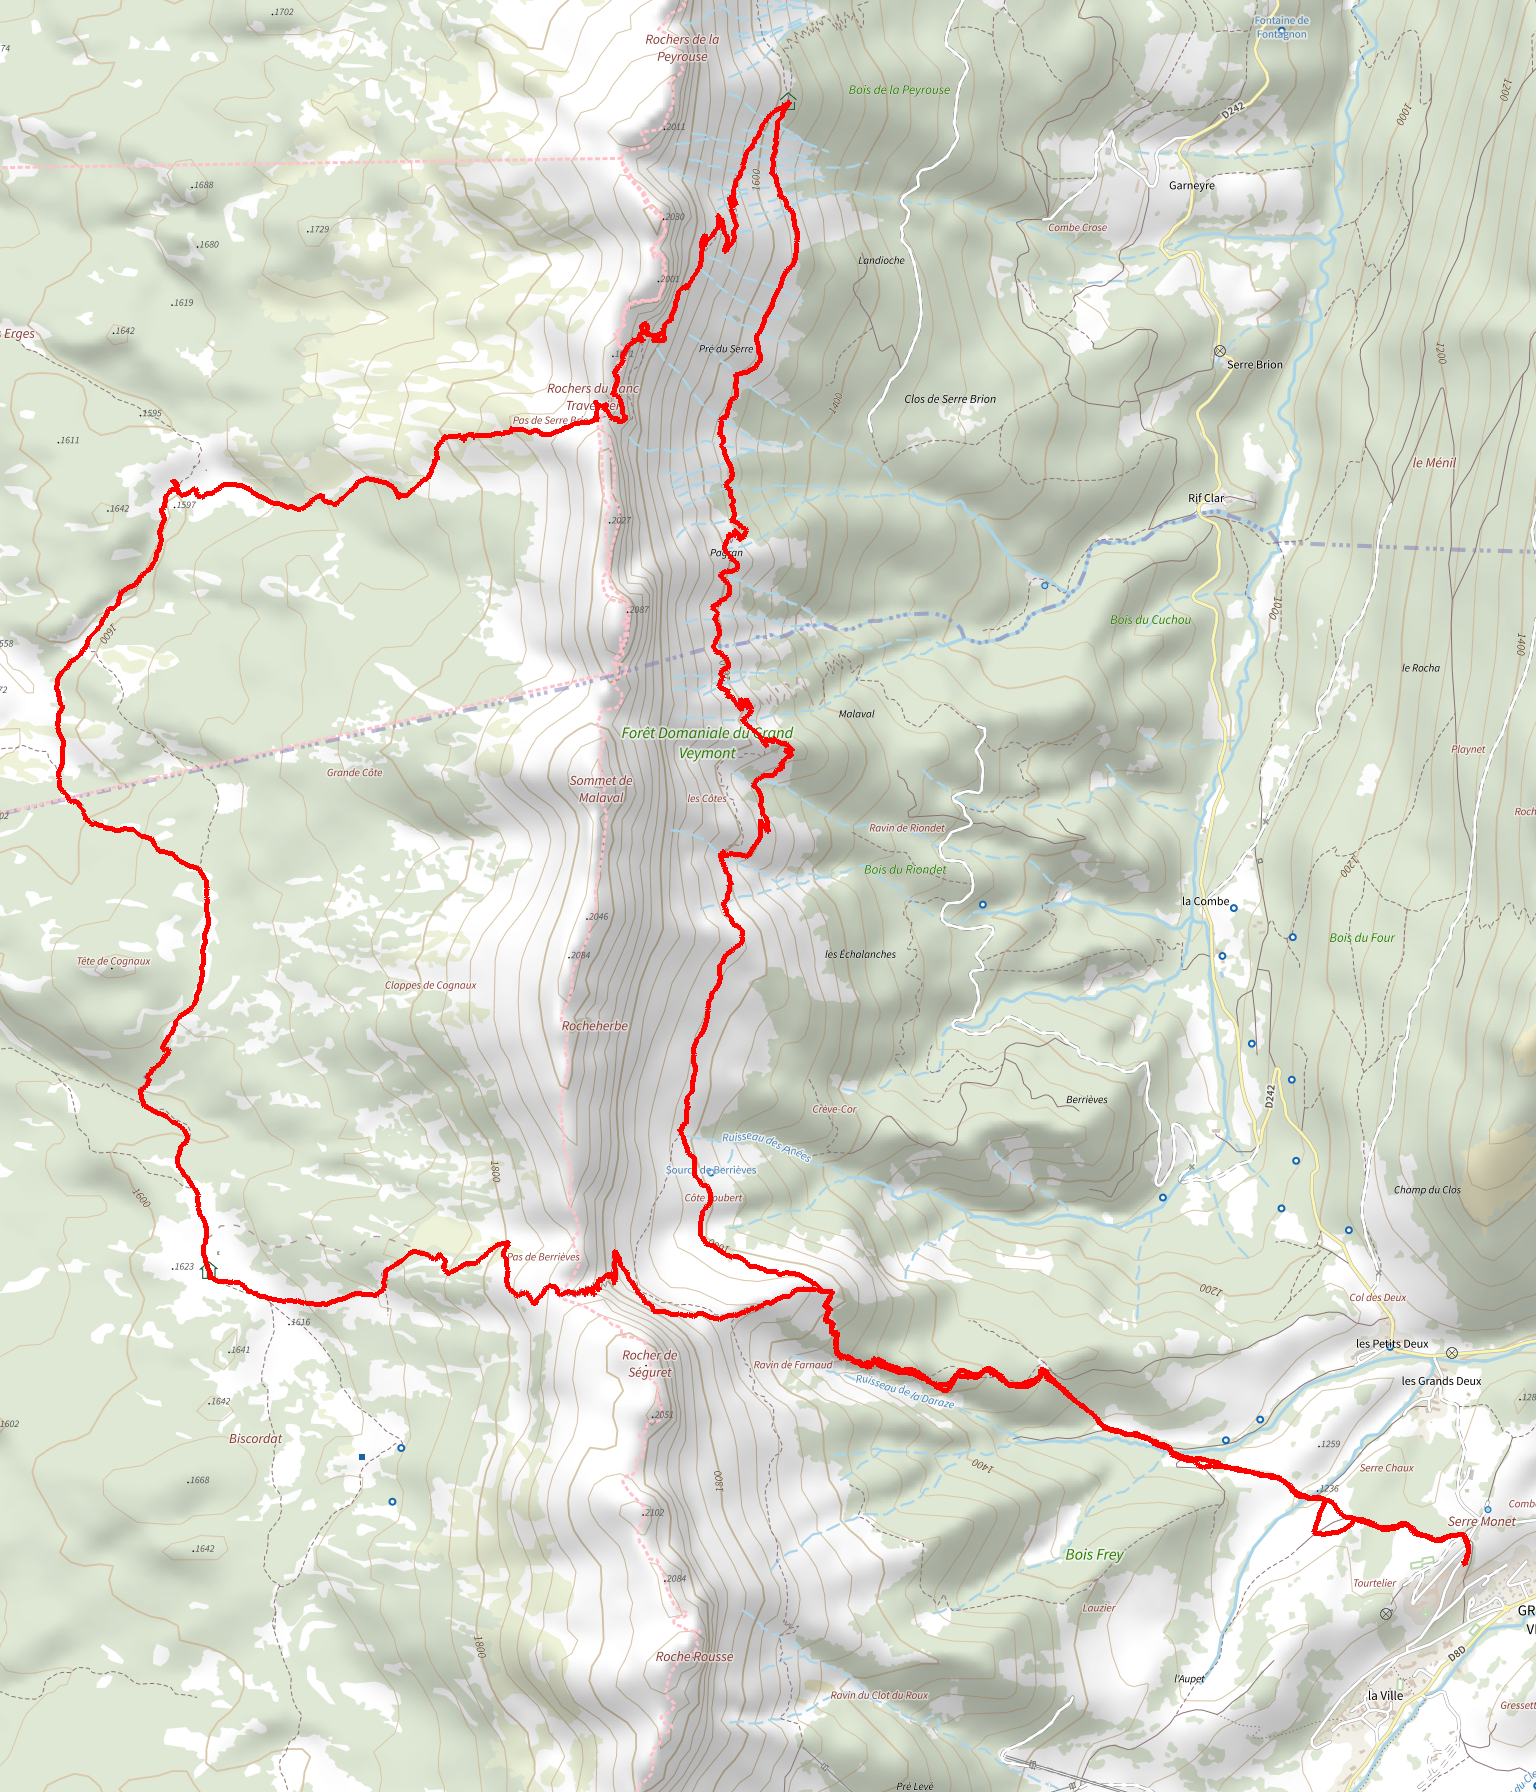

In [11]:
affiche_trace_sur_carte('gpx/trace2.gpx')

In [ ]:
affiche_trace_sur_carte('gpx/trace3.gpx')

In [ ]:
affiche_trace_sur_carte('gpx/trace4.gpx')

In [ ]:
affiche_trace_sur_carte('gpx/trace5.gpx')

In [ ]:
affiche_trace_sur_carte('gpx/trace6.gpx')

In [ ]:
affiche_trace_sur_carte('gpx/trace7.gpx')

In [ ]:
affiche_trace_sur_carte('gpx/trace8.gpx')